# Bike share system in Boston 
#### _Adrien Lagasse, Jeremy Meynier, Alexandre Poinso, Nathalie Tran_

## Introduction

The city of __Boston__, Massachusetts, has launched its bike share program in 2011, called the __Hubway__. There are more than 150 docking stations across the city. The main problem faced by the users is the distribution of the bikes between all the stations. Indeed, one does not want to find an empty station when he needs a bike and he does not want his arrival station to be full as well.  

Full and empty stations are a characteristic of bike share schemes. It goes without saying that users want to be able to pick up or drop off bikes, which is not always possible especially at peak traffic times. Thus, avoiding those situations leads to less complains from frustrated users, more rides and more users which will drive in more revenue. Moreover, optimised redistribution plan can possibly reduce the company’s rebalancing operating expense.

The bikes' operator may handle this issue through several ways. On the one hand, creating new stations can be costly and it may not be able to solve short run problems. On the other hand, we know that the operator is able to use trucks to move bikes across the stations. Hence, better ways to address this short run issue is to move some bikes to prevent bad distribution (empty or full stations), and to inform the users that some stations might be "at risk". We propose to use data science to predict in a 15 minutes time slot the stations that are "at risk", by predicting the number of bikes available in each station. 

This prediction allows the operator to reduce transport costs and to improve user's experience. It is used as a __decision support__ and should be retrained fairly often as new stations can be built in the course of a year. It should also be regularly retrained (such as once a month), as the amount of available data obviouly increases with time.

## The data

The dataset that we provide is sliced into time slots of __15 minutes__.  
It contains, for each time slot :
- the id of the station (an unique `station_id` by station) 
- the number of bikes available
- information about the weather : temperature and rain (supposed to be constant during one hour)
- its capacity (maximum number of bikes)
- its coordinates (latitude and longitude). 

The dataset we provide is the fusion of two public datasets.  
The first one contains the number of bikes in each station in a 15 minutes time slot and was taken from the [Boston Hubway tracking system](http://www.hubwaytracker.com/). As the data were not directly available, we had to scrap the bike availability data from January 2017 to December 2017, which took around half a day. You can ask us if you want to have a look at the code used to scrap the data. The second one gives information about the weather in Boston in a one hour time slot in the year of 2017. We make the assumption that the weather does not change in this slot. It was obtained from the [weathersource API](https://developer.weathersource.com/), where a registered member can access to historical weather information.   

The number of Hubway trips in Boston depend on different elements such as : the time of day, the time of year, the weather. 
We carried out some small exploratory data analyses to understand the variables' influence.
We could notice that users behavior differs in good/bad weather, depends on the day of the week (week days/week end). 

Notice that we cleaned a bit the data : we removed the station name, information about the snowfall (it seems that snowfall is rare). We removed stations that closed or opened during the studied period. 

Let see that more into depth in the following section.

------ 


### Requirements
- numpy>=1.10.0
- pandas>=0.19.0
- matplotlib>=1.5.0
- scikit-learn>=0.17
- folium

To install folium, uncomment the following cell :

In [ ]:
# !pip install folium

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from IPython.display import HTML

### Loading the original dataset

The original dataset contains information of each station from January 2017 to December 2017.

In [3]:
def processing(fichier):
    A = pd.read_csv(fichier, index_col="Unnamed: 0")
    A = A[A["timestamp"] != 0]
    A["timestamp"] = A["timestamp"].apply(lambda x:
    (datetime.datetime.fromtimestamp(x / 1000) +
     datetime.timedelta(hours = -1)).strftime('%H:%M'))
    A["day"] = pd.to_datetime(A["day"])
    A["weekday"] = A["day"].apply(lambda x: x.weekday())
    return A

In [4]:
jan_to_mars = processing("data/raw/bike_availability/bikes_count_jan_mar.csv.bz2") 
apr_to_jun = processing("data/raw/bike_availability/bikes_count_apr_jun.csv.bz2")
jul_to_sep = processing("data/raw/bike_availability/bikes_count_jul_sep.csv.bz2")
oct_to_dec = processing("data/raw/bike_availability/bikes_count_oct_dec.csv.bz2")
bike_availability = pd.concat([jan_to_mars, apr_to_jun, jul_to_sep, oct_to_dec])
# the number of bikes are sometimes float values
# we assume that the number of bikes availaible is the integer part
bike_availability["nb of bikes"] = bike_availability["nb of bikes"].apply(np.int)

In [5]:
bike_availability.head()

,timestamp,nb of bikes,day,station_id,weekday
0,00:00,7,2017-01-01,3,6
1,00:15,7,2017-01-01,3,6
2,00:30,7,2017-01-01,3,6
3,00:45,7,2017-01-01,3,6
4,01:00,7,2017-01-01,3,6


## Taking care of missing stations

At the beginning, we wanted to have a one-year long dataset but we noticed that we did not have the data from all the stations from January to December. We can see on the graph below that the number of available stations is strongly changing during the year. Indeed, there are not even 50 stations available in the beginning of the year. Also, the number of stations available also quickly drop at the end of the year.

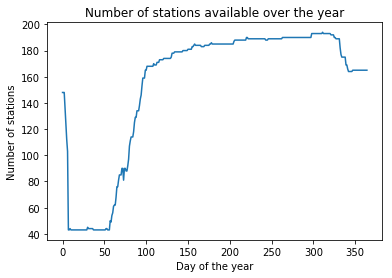

In [6]:
dates = np.unique(bike_availability["day"].values)
nb_station = []
for date in dates:
    nb_station.append(
        len(np.unique(bike_availability[bike_availability["day"] == date]["station_id"].values)))

nb_station = np.array(nb_station)
plt.figure()
plt.plot(nb_station)
plt.title("Number of stations available over the year")
plt.xlabel("Day of the year")
plt.ylabel("Number of stations")
plt.show()

We see that the number of stations available is pretty stable between roughly the 100th day and the 300th day. We decided to consider only the part of the dataset from the first day it reaches 179 stations to the last day there are 189 stations available as a trade-off in order to consider a significant amount of stations. Those missing stations will have an impact on the prediction performance but it should be fine considering we only drop a small percentage of them.

In [7]:
print("The first day it reaches 179 stations is the {}th day \
and the last day there are 189 stations is the {}th day."
      .format(np.where(nb_station == 179)[0][0], np.where(nb_station == 189)[0][-1]))

The first day it reaches 179 stations is the 134th day and the last day there are 189 stations is the 331th day.


However, we will take the 330th day to avoid side effects (some stations might close this day).

In [8]:
limited_bike_counts = bike_availability.set_index("day")[dates[134]:dates[331]].reset_index("day")

We only keep the stations' id that were available throughout this period.

In [9]:
# unique_id : id des stations présentes chaque jour
unique_id = set(np.unique(limited_bike_counts[limited_bike_counts["day"] == dates[134]]["station_id"].values))
for i in range(135, 332):
    v = np.unique(limited_bike_counts[limited_bike_counts["day"] == dates[i]]["station_id"].values)
    unique_id = unique_id & set(v)

limited_bike_counts = limited_bike_counts[limited_bike_counts["station_id"].isin(unique_id)]

In [10]:
# Some timestamps have weirdly a 1-minute shift, we take care of that
minutes = np.array([int(a[-1]) for a in limited_bike_counts["timestamp"].values]) # minute info
shifted = np.where(minutes % 5 != 0)[0] # lines where there is a shift

def shift(x):
    a = x[0:4]
    b = str(int(x[-1]) - 1)
    return a + b

In [11]:
U = limited_bike_counts.iloc[shifted, 1].values
for i in range(len(U)):
    U[i] = shift(U[i])
    
limited_bike_counts.iloc[shifted, 1] = U

In [12]:
limited_bike_counts["hour"] = limited_bike_counts["timestamp"].apply(lambda x: int(x[0:2]))
limited_bike_counts.reset_index(inplace=True, drop=True)
limited_bike_counts.head()

,day,timestamp,nb of bikes,station_id,weekday,hour
0,2017-05-15,00:00,6,3,0,0
1,2017-05-15,00:15,12,3,0,0
2,2017-05-15,00:30,12,3,0,0
3,2017-05-15,00:45,12,3,0,0
4,2017-05-15,01:00,12,3,0,1


So instead of considering a one-year long dataset, we are limited to data from mid May to end of November.  
We can visualize the considered stations on a map. We can get the stations information from the Hubway website.

In [13]:
station_info = pd.read_csv("data/raw/stations_information_from_jul2017.csv")
station_info = (station_info[station_info["station_id"].isin(unique_id)]
                [["Latitude","Longitude", "# of Docks", "station_id"]])
station_info.head()

,Latitude,Longitude,# of Docks,station_id
2,42.353287,-71.044389,15,7
3,42.353334,-71.137313,15,8
4,42.351246,-71.115639,19,9
5,42.350406,-71.108279,11,10
6,42.338629,-71.106500,15,11


In [15]:
mean_lat = station_info["Latitude"].mean()
mean_long = station_info["Longitude"].mean()
stations_map = folium.Map(location=[mean_lat, mean_long],
                          zoom_start=12, min_zoom=12)

lons = []
lats = []

for station in station_info.iterrows():
    lons.append(station[1]["Longitude"]) 
    lats.append(station[1]["Latitude"] )

# build and display map
# correct the markers adding clustered markers
locations = list(zip(lats, lons))
popups = ['{}'.format(loc) for loc in locations]
stations_map.add_child(MarkerCluster(locations=locations, popups=popups))    
stations_map

By downloading the [trip history data](https://s3.amazonaws.com/hubway-data/index.html) for the period of interest, we can visualize the following graphs.

In [17]:
trips = pd.read_csv('data/raw/trips/trips_15may_28nov.csv.bz2')
trips.rename(columns={"st_date": "day"}, inplace=True)
trips = trips[trips["start station id"].isin(unique_id)]

We can see that the mean duration of trips is around 19 minutes, so retrieving the bike availability in a 15-minute time slot is wise.

In [18]:
trips.tripduration_min.describe()

count    969491.000000
mean         19.089792
std         182.819564
min           1.016667
25%           6.816667
50%          11.350000
75%          18.450000
max       49301.733333
Name: tripduration_min, dtype: float64

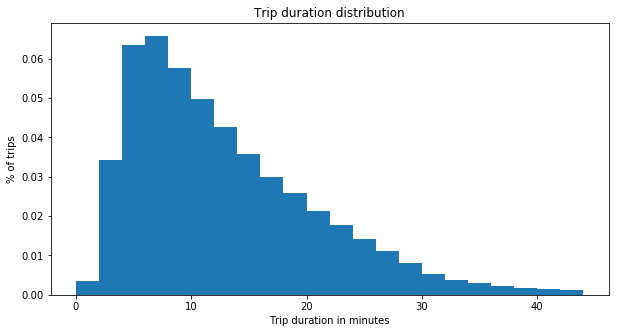

In [19]:
plt.figure(figsize=(10,5))
plt.hist(trips.tripduration_min, bins=range(0, 45, 2), normed=True)
plt.xlabel('Trip duration in minutes')
plt.ylabel('% of trips')
plt.title('Trip duration distribution')
plt.show()

In the original weather information dataset, we initially had a feature called __snowfall__ but decided to discard it because it seemed that the number of day with snow was relatively small and didn't give much information. Indeed, as we are limited to a subset of our complete dataset, the snow didn't have much influence.  
We can justify the use of the meteorological information in our dataset. Indeed we can see the influence of the temperature and the rain on the number of bike trips in Boston.

In [20]:
weather = pd.read_csv("data/raw/weather/weather_clean.csv")
weather.rename(columns={"date" : "day"}, inplace=True)
weather["day"] = pd.to_datetime(weather["day"])
weather = weather.set_index("day")["2017-05-15":"2017-11-28"].reset_index("day")

In [21]:
weather.head()

,day,precip,temp,hour,weekday
0,2017-05-15,0.00,49.9,0,0
1,2017-05-15,0.00,49.8,1,0
2,2017-05-15,0.00,49.5,2,0
3,2017-05-15,0.00,49.0,3,0
4,2017-05-15,0.01,48.3,4,0


In [22]:
trips.day = pd.to_datetime(trips.day)
trips_by_hour = pd.DataFrame(trips.groupby(['day', 'st_hour'])['bikeid'].count())
trips_by_hour.columns = ['nb of trips']
trips_weather = pd.merge(trips_by_hour, weather, how='left', left_index=True, right_on=['day', 'hour'])
trips_weather['week'] = trips_weather.weekday < 5
trips_weather['rained'] = trips_weather.precip > 0
trips_weather.head()

,nb of trips,day,precip,temp,hour,weekday,week,rained
0,24,2017-05-15,0.00,49.9,0,0,True,False
1,16,2017-05-15,0.00,49.8,1,0,True,False
2,4,2017-05-15,0.00,49.5,2,0,True,False
3,3,2017-05-15,0.00,49.0,3,0,True,False
4,2,2017-05-15,0.01,48.3,4,0,True,True


We can make hourly averages to observe the influence of the rain on the number of bike trips on week days and on the week end.

In [23]:
hourly_averages = trips_weather.groupby(['week', 'rained', 'hour'])['nb of trips'].mean()

We can clearly notice that people avoid using bikes when it rains. During the week, we can also deduce that the peak time are early in the morning (8am-9am) and in the late evening (5-6pm).

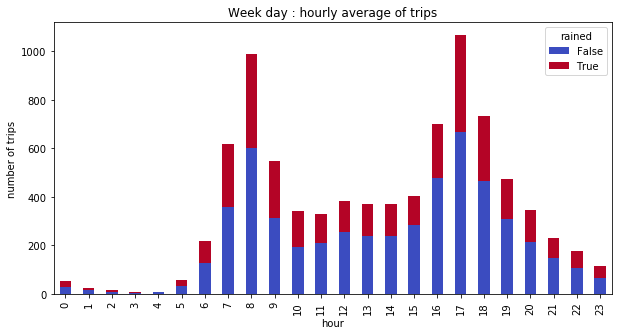

In [24]:
ax = (hourly_averages.loc[True].unstack(level=0)
      .plot(kind='bar', figsize=(10, 5), colormap='coolwarm', stacked=True,
            title='Week day : hourly average of trips'))
ax.set_ylabel('number of trips');

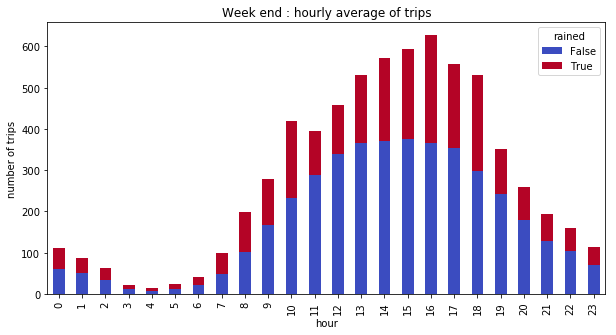

In [25]:
ax = (hourly_averages.loc[False].unstack(level=0)
      .plot(kind='bar', figsize=(10, 5), colormap='coolwarm', stacked=True,
            title='Week end : hourly average of trips'))
ax.set_ylabel('number of trips');

Now we can see the influence of the temperature. The temperature are in degrees __Fahrenheit__.  
As expected, when it is cold, people do not use the bike as much as when it is warmer.

In [26]:
trips_weather.temp.describe()

count    4744.000000
mean       63.692580
std        12.319799
min        22.700000
25%        57.000000
50%        65.100000
75%        72.300000
max        93.800000
Name: temp, dtype: float64

In [27]:
bins = [ 22.7,  32.7,  42.7,  52.7,  62.7,  72.7,  82.7, 93.8]
labels = ['22-32', '32-43', '43-52', '52-62', '62-72', '72-82', '82-93']
trips_weather['ten_degrees_range'] = pd.cut(trips_weather.temp,
                                            bins=bins, labels=labels,
                                            include_lowest=True)

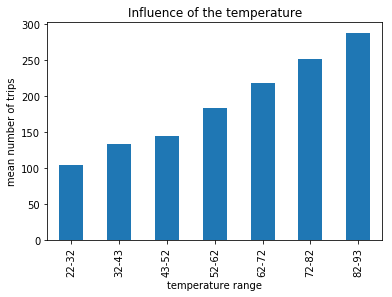

In [28]:
ax = (trips_weather.groupby('ten_degrees_range')['nb of trips']
      .mean().plot(kind='bar', title='Influence of the temperature'))
ax.set_xlabel('temperature range')
ax.set_ylabel('mean number of trips');

We can also underline the fact that some stations are more visited. Trips are not uniformly distributed across the city. As a result, some stations have more arrivals and departures than others.  
Moreover, one could try to see if the number of incoming and outgoing trips changes across hours of the day.

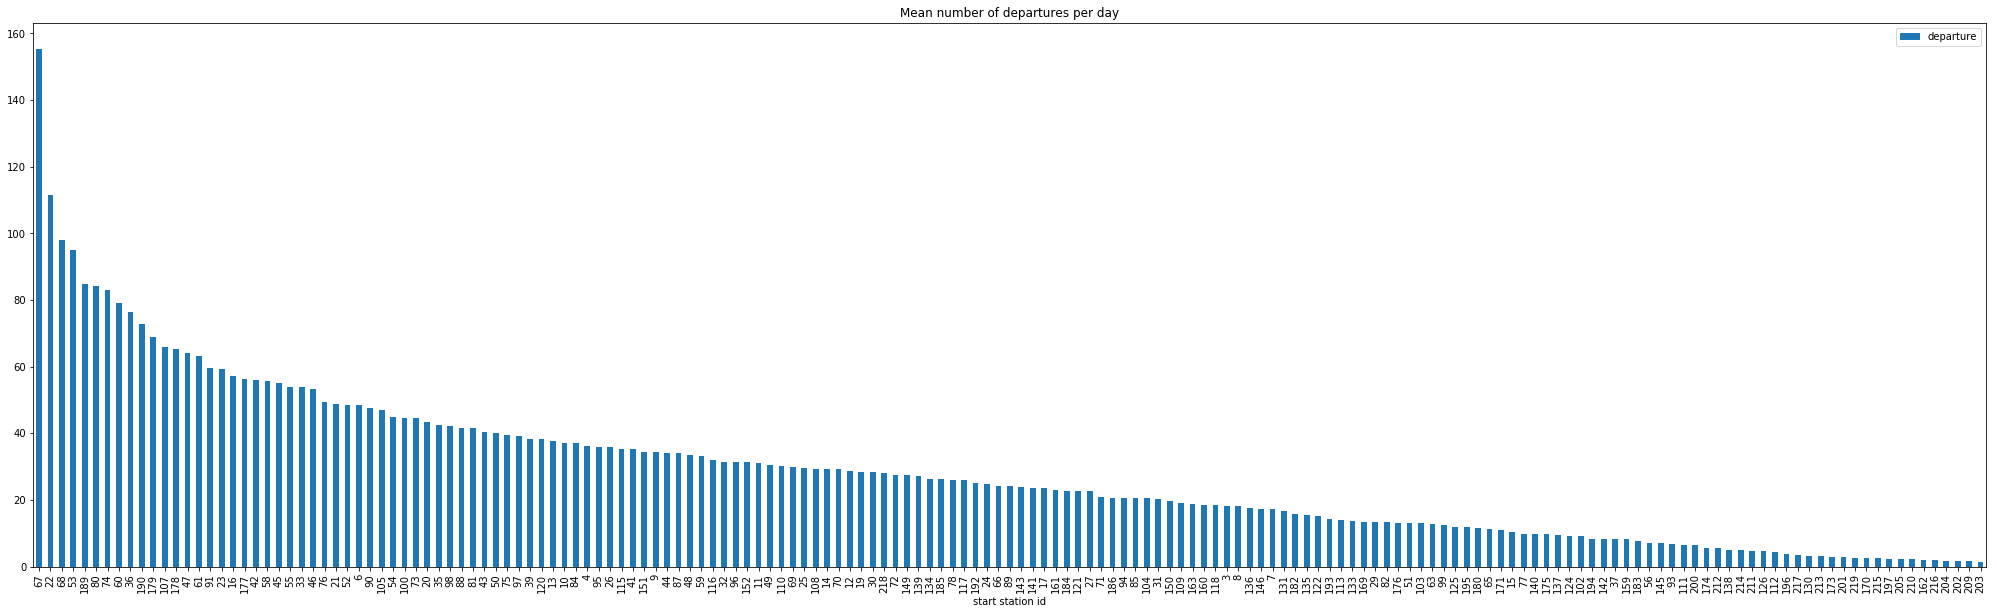

In [29]:
trips_departure = (trips
                   .groupby(["day","start station id"])
                   .count().reset_index(["day","start station id"])
                   [["day","start station id", "starttime"]]
                   .rename(columns={"starttime":"departure"}))

(trips_departure.groupby("start station id")
 .mean().sort_values(by="departure", ascending=False)
 .plot(kind="bar", figsize=(35, 10), title="Mean number of departures per day"));

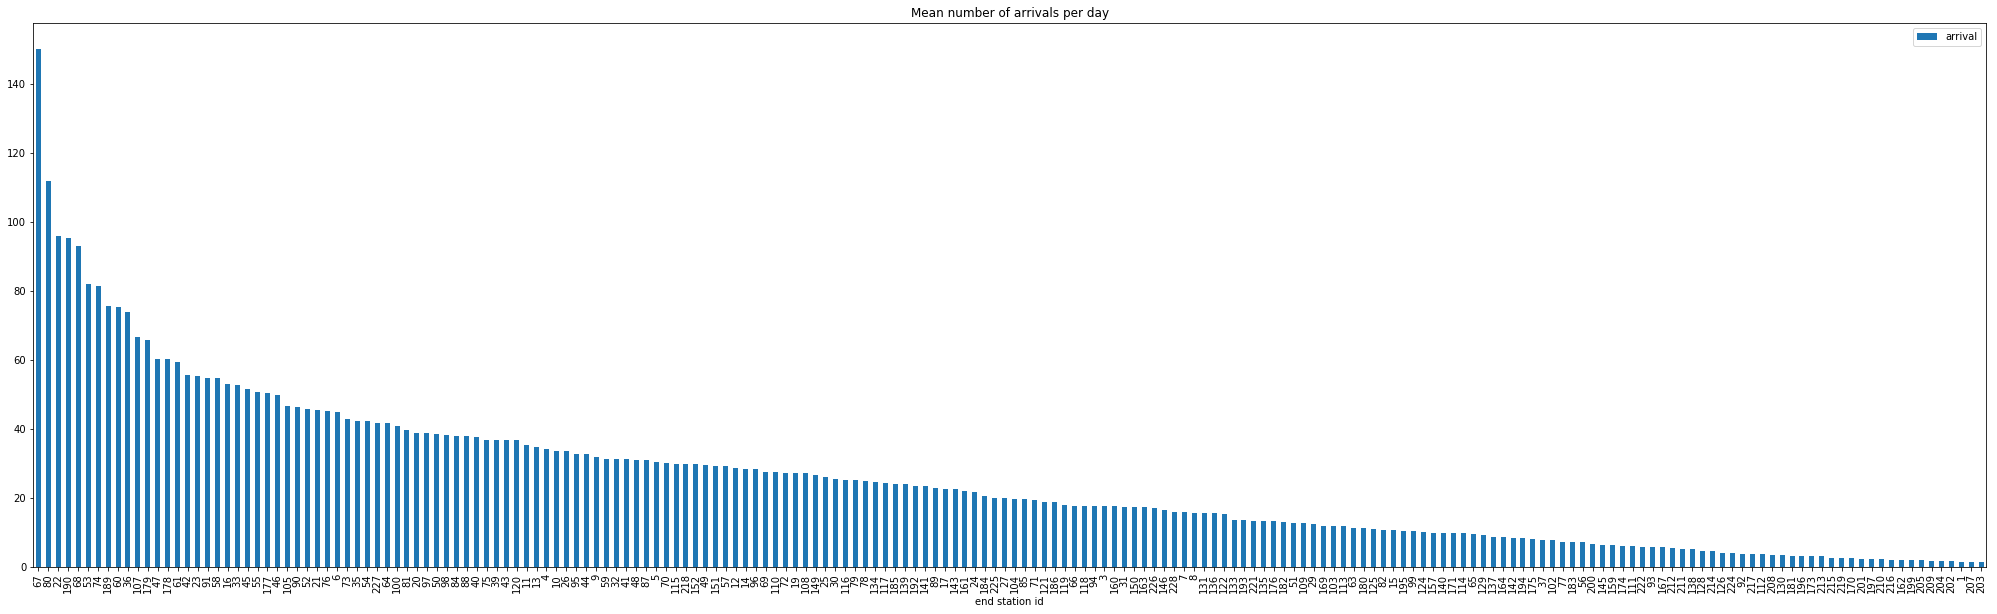

In [30]:
trips_arrival = (trips
                 .groupby(["day","end station id"])
                 .count().reset_index(["day","end station id"])
                 [["day","end station id", "starttime"]]
                 .rename(columns={"starttime":"arrival"}))
(trips_arrival.groupby("end station id")
 .mean().sort_values(by="arrival", ascending=False)
 .plot(kind="bar", figsize=(35, 10), title="Mean number of arrivals per day"));

We have seen that the weather conditions have an influence on the bike usage and are relevant features to predict the number of bikes in a station. Moreover, some stations are more visited than others which justify the fact that empty or full stations are not uncommon.  
Thus, predicting the stations that are at risk of being full/empty is crucial to fulfill the __user's need__ and to help the company __rebalancing__ the bikes through the network of stations.

We can now merge the two seperate dataset :

In [31]:
weather.drop(["weekday"], axis=1, inplace=True)
bikes_weather = pd.merge(weather, limited_bike_counts, on=["day", "hour"])

In [32]:
bikes_weather.head()

,day,precip,temp,hour,timestamp,nb of bikes,station_id,weekday
0,2017-05-15,0.0,49.9,0,00:00,6,3,0
1,2017-05-15,0.0,49.9,0,00:15,12,3,0
2,2017-05-15,0.0,49.9,0,00:30,12,3,0
3,2017-05-15,0.0,49.9,0,00:45,12,3,0
4,2017-05-15,0.0,49.9,0,00:00,10,4,0


It remains that we complete our dataframe with each station information.

In [33]:
complete_df = pd.merge(station_info, bikes_weather, on="station_id")
complete_df = complete_df.reindex(columns=['day', "timestamp", 'weekday', 'hour', "precip", "temp",
                            "station_id","Latitude", "Longitude", "nb of bikes", "# of Docks"])
complete_df = complete_df.sort_values(by=['day', 'timestamp', 'station_id'])
complete_df.reset_index(inplace=True, drop=True)

In [34]:
complete_df.head()

,day,timestamp,weekday,hour,precip,temp,station_id,Latitude,Longitude,nb of bikes,# of Docks
0,2017-05-15,00:00,0,0,0.0,49.9,3,42.340021,-71.100812,6,15
1,2017-05-15,00:00,0,0,0.0,49.9,4,42.345392,-71.069616,10,15
2,2017-05-15,00:00,0,0,0.0,49.9,6,42.361174,-71.065142,7,15
3,2017-05-15,00:00,0,0,0.0,49.9,7,42.353287,-71.044389,3,15
4,2017-05-15,00:00,0,0,0.0,49.9,8,42.353334,-71.137313,13,15


## Taking care of missing time slots  

In the midst of our data cleaning/tidying steps, we have sadly found out that some times slots were missing for several stations. It might be due to technical problems : the tracking done by the __Hubway__ system data center at certain stations stopped working for multiple periods of time.

In order to work around it, we added the missing time slots with `NaN` values in the column `nb of bikes`.  
One may think of a more sophisticated method to fill the missing data (like taking the mean of number of bikes in the time period) but the amount of missing values is negligible so we only propagated the last valid observation forward to next valid. It should not impact the final prediction of the regressor.

## Train / Test set  

We want to predict the number of bikes for each station and each time slot for the last week of our period : 2017-11-20 to 2017-11-27.  
So, we decided to split the dataset in two :
- train dataset : data until 20 nov 2017
- test dataset : the last week of the dataset

## Loading the data

One can easily load the data, as shown below.

In [38]:
train_filename = 'data/train.csv.bz2'
data = pd.read_csv(train_filename)
data.head()

,day,timestamp,weekday,hour,precip,temp,station_id,Latitude,Longitude,nb of bikes,# of Docks
0,2017-05-15,00:00,0,0,0.0,49.9,3,42.340021,-71.100812,6.0,15
1,2017-05-15,00:00,0,0,0.0,49.9,4,42.345392,-71.069616,10.0,15
2,2017-05-15,00:00,0,0,0.0,49.9,6,42.361174,-71.065142,7.0,15
3,2017-05-15,00:00,0,0,0.0,49.9,7,42.353287,-71.044389,3.0,15
4,2017-05-15,00:00,0,0,0.0,49.9,8,42.353334,-71.137313,13.0,15


Most columns are measurement data (discrete and continuous).

In [39]:
data.dtypes

day             object
timestamp       object
weekday          int64
hour             int64
precip         float64
temp           float64
station_id       int64
Latitude       float64
Longitude      float64
nb of bikes    float64
# of Docks       int64
dtype: object

In [40]:
data.count()

day            3119040
timestamp      3119040
weekday        3119040
hour           3119040
precip         3119040
temp           3119040
station_id     3119040
Latitude       3119040
Longitude      3119040
nb of bikes    3119040
# of Docks     3119040
dtype: int64

The training dataframe has 3 000 000+ instances.

In [41]:
print(np.unique(data['station_id']))
print(len(np.unique(data['station_id'])))

[  3   4   6   7   8   9  10  11  12  13  14  15  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  32  33  35  36  37  39  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  58  59  60  61  63  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  80  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 102 103 104 105 107
 108 109 110 111 112 113 115 116 117 118 120 121 122 124 125 126 130 131
 133 134 135 136 137 138 139 140 141 142 143 145 146 149 150 151 152 159
 160 161 162 163 169 170 171 173 174 175 176 177 178 179 180 182 183 184
 185 186 189 190 192 193 194 195 196 197 200 201 202 203 204 205 209 210
 211 212 213 214 215 216 217 218 219]
171


There are 171 different stations which we want to predict the number of bikes.

In [42]:
data['# of Docks'].describe()

count    3.119040e+06
mean     1.761404e+01
std      4.471173e+00
min      1.100000e+01
25%      1.500000e+01
50%      1.500000e+01
75%      1.900000e+01
max      4.600000e+01
Name: # of Docks, dtype: float64

Most of the stations have around 15 or 20 docks for bikes.

We can see how many days it has rained (`precip` > 0) during the whole period of our dataset.

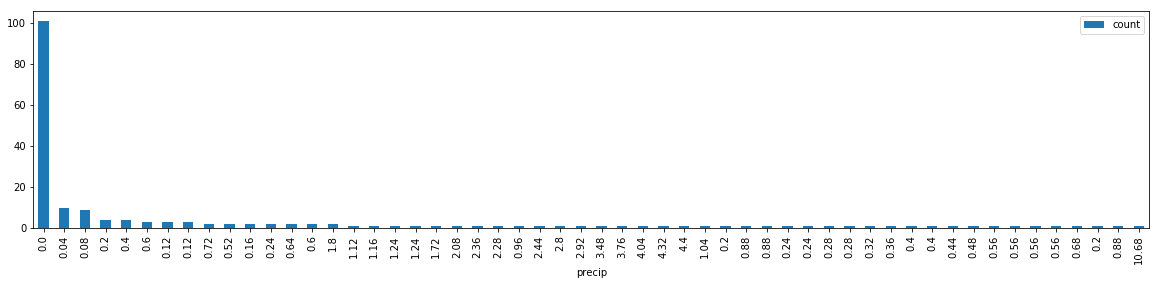

In [43]:
(data[data['station_id'] == 3].groupby(['day']).sum()
 .groupby('precip').count()[["weekday"]]
 .sort_values('weekday', ascending=False)
 .reset_index().rename(columns={'weekday': 'count'})
 .plot.bar(x='precip', y='count', figsize=(20, 4), fontsize=10));

The range of temperature goes from 22.7°F (-5°C) to 93.8°F (34°C).

In [44]:
data.temp.describe()

count    3.119040e+06
mean     6.460353e+01
std      1.159106e+01
min      2.270000e+01
25%      5.800000e+01
50%      6.570000e+01
75%      7.260000e+01
max      9.380000e+01
Name: temp, dtype: float64

We can also observe the occupancy rate of each station during peak hours (8-9am and 5-6pm, except for the week-end).

In [45]:
data["fullness"] = data["nb of bikes"] / data["# of Docks"]

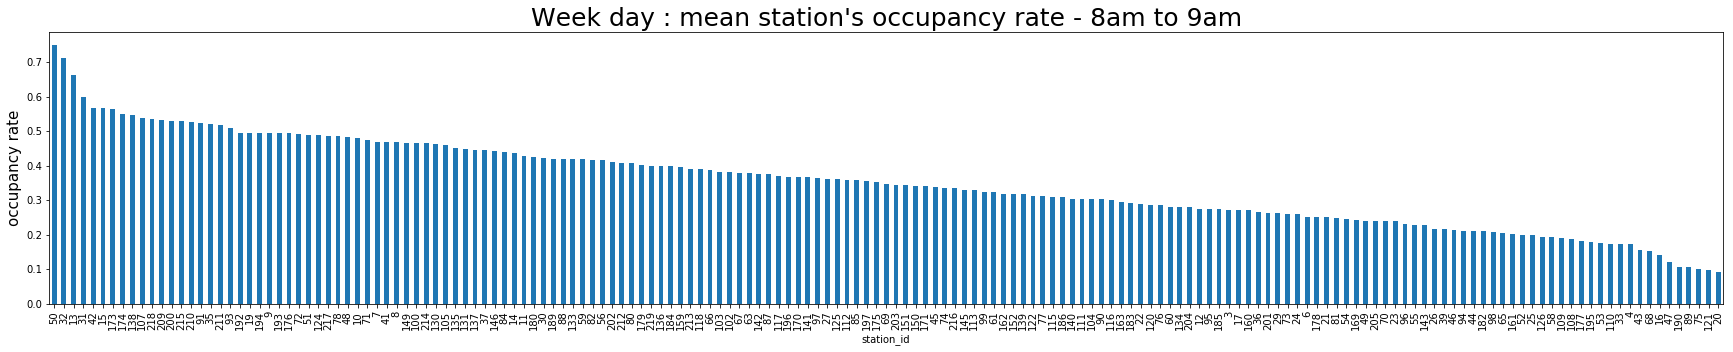

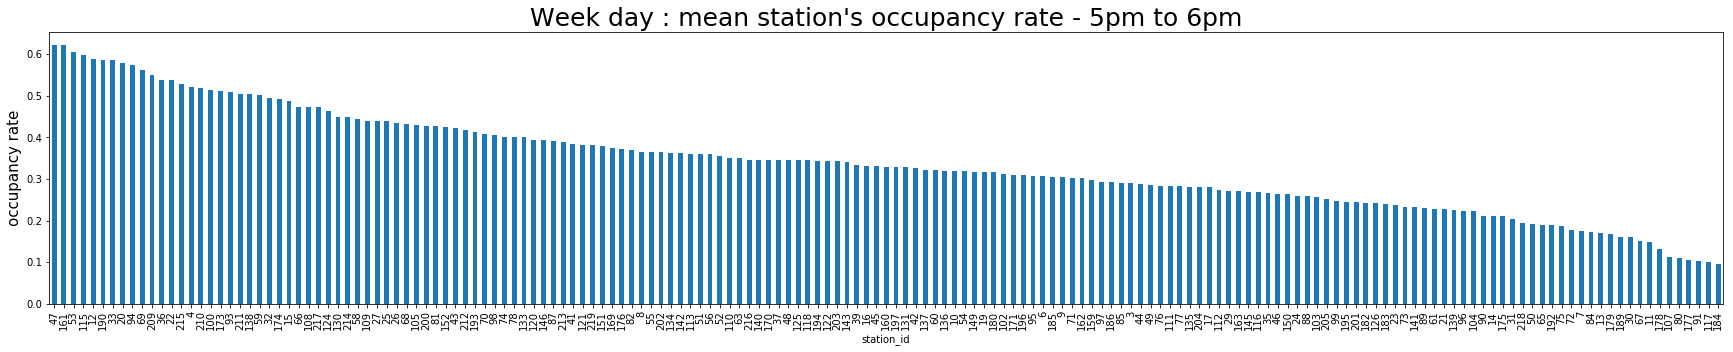

In [46]:
# peak hours
peak_8am = data[(data["hour"] == 8) & (data["weekday"] < 5)]
peak_8am = peak_8am.groupby("station_id").mean()
peak_8am = (peak_8am.sort_values(by="fullness", ascending=False))["fullness"]
peak_8am.plot(kind="bar", figsize=(30, 5))
plt.title("Week day : mean station's occupancy rate - 8am to 9am", fontsize=25)
plt.ylabel("occupancy rate", fontsize=15);

plt.figure()
peak_5pm = data[(data["hour"] == 17) & (data["weekday"] < 5)]
peak_5pm = peak_5pm.groupby("station_id").mean()
peak_5pm = (peak_5pm.sort_values(by="fullness", ascending=False))["fullness"]
peak_5pm.plot(kind="bar", figsize=(30, 5))
plt.title("Week day : mean station's occupancy rate - 5pm to 6pm", fontsize=25)
plt.ylabel("occupancy rate", fontsize=15);

Hubway trips results in station being full or empty. The following graphs depict the proportions of time empty v. full from May to November. It is clear that on average, stations are more often empty than full. 

In [47]:
data['status'] = pd.np.where(data.fullness == 1., 'full',
                             np.where(data.fullness == 0., 'empty',
                                      'available'))

status = pd.DataFrame(data['station_id'].value_counts()).reset_index()
status.columns = ['station_id', 'count']

status_frequence = data.groupby(['station_id', 'status']).count().reset_index()
status_frequence = pd.merge(status_frequence, status, how='left', on='station_id')
status_frequence = status_frequence[status_frequence.status != 'available']
status_frequence['freq'] = status_frequence.fullness / status_frequence['count']

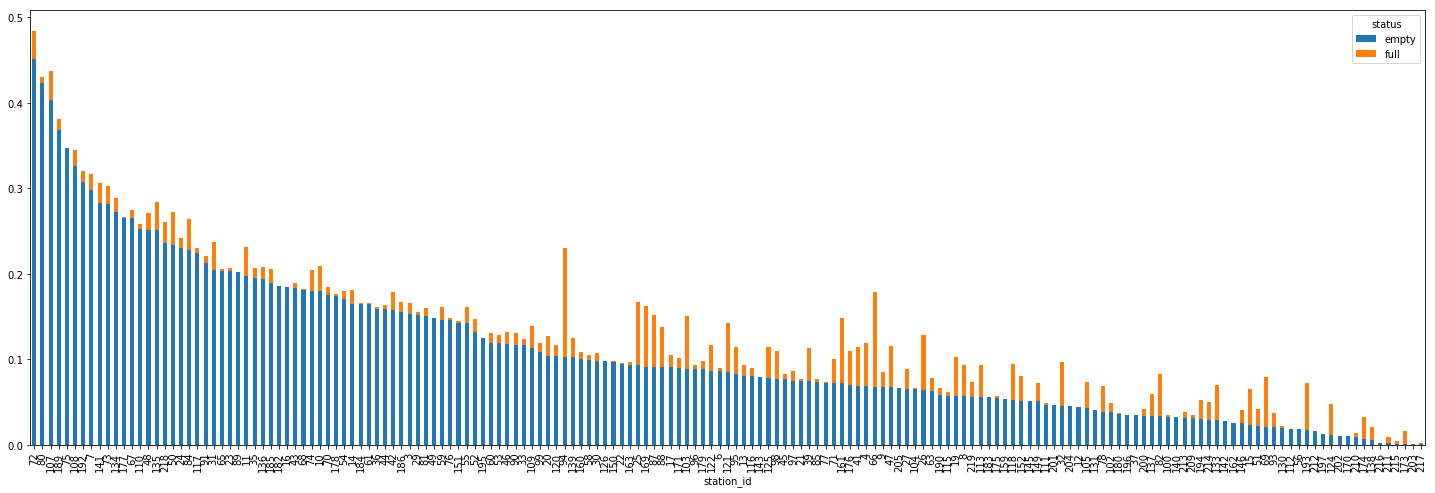

In [48]:
(status_frequence
 .groupby(['status', 'station_id'])['freq']
 .median()
 .unstack(level=0).fillna(0).sort_values(by='empty', ascending=False)
 .plot(kind='bar', figsize=(25, 8), stacked=True));

We can also visualize separately the two plots :

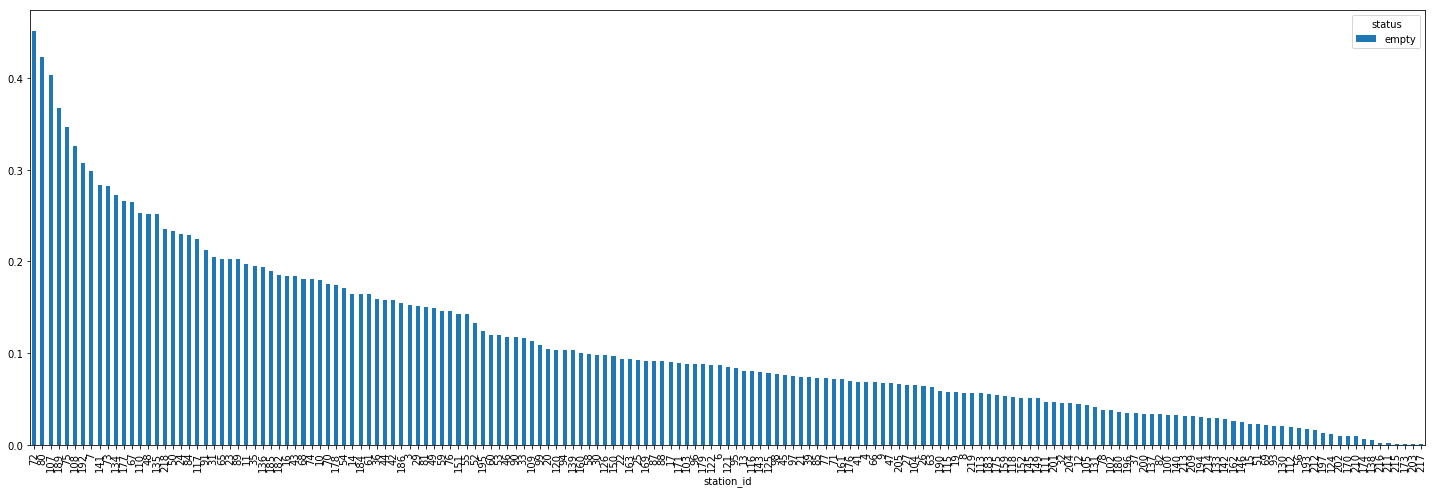

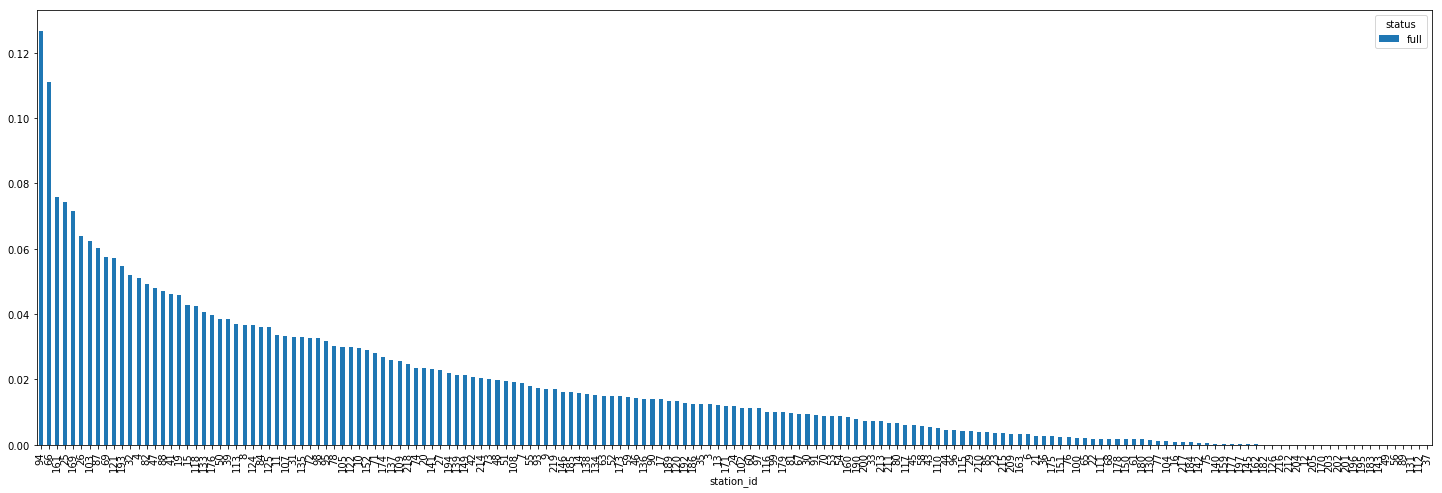

In [49]:
# empty frequence
(status_frequence
 .groupby(['status', 'station_id'])['freq']
 .median()
 .unstack(level=0).fillna(0).sort_values(by='empty', ascending=False)[['empty']]
 .plot(kind='bar', figsize=(25, 8)));

# full frequence
(status_frequence
 .groupby(['status', 'station_id'])['freq']
 .median()
 .unstack(level=0).fillna(0).sort_values(by='full', ascending=False)[['full']]
 .plot(kind='bar', figsize=(25, 8)));

---- 
## Scores

### Mean Absolute Error
We simply compute the absolute error between the number of bikes we predicted at each station and the real number of bikes during all the test period (last week from the dataset). Then we compute the mean of all those values. 
This score is extremely simple but it is also easily understandable, so it gives directly a pretty good idea of the model's performance.

### Danger score
The idea behind this score is to penalize predictions that failed to predict stations at risk and predictions that falsely predict stations at risk.
We define stations at risk as the stations that :
- contain less that 10% of their capacity (considered as "almost empty")
- contain more that 90% of their capacity (considered as "almost full")

We are not especially interested in computing all the exact number of bikes in each station. We just want to prevent stations being at risk (as defined before). 

We came up with the following score to penalize much more the predictions that are not able to anticipate risky situations.

$$\frac{1}{n_{stations} * T} \sum_{t \in [1, T]} {\sum_{i \in \text{stations}}{| y_{i, t} - \hat{y}_{i, t} | \ (1 + 2\  \mathbb{1}_{(y_{i, t} \in R_i, \hat{y}_{i, t} \notin R_i)} + \mathbb{1}_{(y_{i, t} \notin R_i, \hat{y}_{i, t} \in R_i)})}}$$

with 

- $T$ : the number of time slots in the test period
- $n_{stations}$ : the number of stations
- $R_i$ : the risk interval for the i-th station
- $y_{i, t}$ : the ground truth at station i at time t
- $\hat{y}_{i, t}$ : the prediction at station i at time t

If we miss a risky station at a given time, we penalize it more than if we wrongly predict that it is at risk. Indeed, if we are not able to anticipate a risky station, we cannot solve the issue. But at the same time, we don't want to predict crisis if they don't happen as it will imply that we take actions that are not needeed (to rebalance the bikes across the network with trucks or give false information).

The aim of the challenge is of course to find a predictive model that minimizes this Danger score.

----

## The pipeline   

The task in this challenge is to predict the number of bikes available in each station for each time slot of the test dataset. This is a regression task, with the constraint that the predictions must be __integers__ (we predict a number of bikes, so it cannot be a float !).

For submitting at the RAMP site, you will have to write two classes, saved in two different files:

- a class FeatureExtractor, which will be used to extract features for regression from the dataset
- a class Regressor to predict

## Feature extractor  

The feature extractor implements a transform function. It is saved in the file submissions/starting_kit/feature_extractor.py. It receives the pandas dataframe X_df defined at the beginning of the notebook.

__Note__: the following code cells are not executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [ ]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class FeatureExtractor():

    def __init__(self):
        pass

    def fit(self, X_df, y=None):
        pass

    def transform(self, X_df):
        lats = np.unique(X_df['Latitude'].values)
        longs = np.unique(X_df['Longitude'].values)
        nb_docks = np.unique(X_df['# of Docks'].values)
        X_df = X_df.copy()
        X_df.drop(['Latitude', 'Longitude', '# of Docks'], axis=1, inplace=True)

        X_df['time'] = pd.to_datetime(X_df['day'] + ' ' +  X_df['timestamp'])
        X_df.drop(['day', 'timestamp'], axis=1, inplace=True)

        ohe_day = OneHotEncoder()
        ohe_hour = OneHotEncoder()

        weekday_unq = np.unique(X_df['weekday'])
        week_day = X_df['weekday'].values
        ohe_day.fit(weekday_unq.reshape(-1, 1))
        week_day_ohe_sparse = ohe_day.transform(week_day.reshape(-1, 1))

        hour_unq = np.unique(X_df['hour'])
        hours = X_df['weekday'].values
        ohe_hour.fit(hour_unq.reshape(-1, 1))
        hours_ohe_sparse = ohe_hour.transform(hours.reshape(-1, 1))

        temp = X_df['temp'].values
        rain_fall = X_df['precip'].values

        return np.c_[week_day_ohe_sparse.todense(), hours_ohe_sparse.todense(), temp, rain_fall]

In this first sketch of `FeatureExtractor`, we show some interesting tips. Indeed, one can extract the coordinates and the capacity of the stations, that are redundant among the DataFrame. We did not use them in this first sketch, but one can think of useful usages. 
Moreover, we used one hot encoding to take into account the time. This is a first solution, but one may have other ideas.

## Regressor  

The regressor follows a classical scikit-learn regressor template. It should be saved in the file submissions/starting_kit/regressor.py. In its simplest form it takes a scikit-learn pipeline, assigns it to self.reg in `__init__`, then calls its fit and predict functions in the corresponding member functions. The predict function should return an __array__. Note that this array __must be ordered__ as the test dataset, i.e. keep first the order between the time slots, and second for each time slot, the order between stations.

In [ ]:
%%file submissions/starting_kit/regressor.py
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.linear_model import BayesianRidge

# Remember : there are 171 stations

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = []
        for i in range(171):
            self.reg.append(BayesianRidge())

    def fit(self, X, y):
        for i in range(171):
            self.reg[i].fit(X[i::171], y[i::171].ravel())

    def predict(self, X):
        nb_rows = X.shape[0]
        y_tmp = []
        for i in range(171):
            y_tmp.append(self.reg[i].predict(X[i::171]))
        y_tmp = np.array(y_tmp)
        y_final = []
        for j in range(len(y_tmp[0])):
            for k in range(171):
                y_final.append(max(0, np.int(y_tmp[k][j])))
        return np.array(y_final)[:, np.newaxis]

As for the feature extractor, this is only a first sketch. This first solution shows how to create 171 independent predictors (one for each station), and how to deal with the constraint that the predicted array must be ordered. It also shows tips to predict integers values, that are nonnegative, as the capacity of each station is of course positive.  
Of course, one may thinks of other predictors.

---

## The Cross-Validation

To test locally your submission files (see below), a cross-validation scheme is implemented. 
Contrary to many Machine Learning tasks, we cannot simply randomly shuffle the dataset and select a subset to be a test set, and the remaining part to be the training set. Indeed, we are dealing with time series, so the order of the data is important, and random shuffles will lose causality.  

Therefore, the Cross-Validation scheme for this challenge is the classic scheme for time series. It works as follows : 
- The first training set contains the first data (chronogically speaking) of the dataset.
- The first test set contains the data that follows the data of the training set in the dataset.
- A first model is fitted on the training set, and outputs predictions on the test set, which leads to a first score.
- A new training set is created, containing the previous training set and the previous test set.
- A new test set is created, containing the data that follows the data of the new training set in the dataset.
- We can fit a new model, and compute a new score.
- These operations are repeated until we reach the number of folds required. 

Note that contrary to classic Cross-Validation scheme (e.g. K-Fold), the size of the training set is increasing with each fold.  
In our case, we have 5 folds, each test set represents one week, and the first training set represents around four months and a half.

---

## Local testing (before submission)  

It is __important that you test your submission files before submitting them__. For this we provide a unit test. Note that the test runs on your files in `submissions/starting_kit`, not on the classes defined in the cells of this notebook.

First install ramp-workflow (either by runnig `pip install ramp-workflow` in a terminal or installing it from the github repo). Make sure that the python files `feature_extractor.py` and `regressor.py` are in the  `submissions/starting_kit` folder, and the data `train.csv.bz2` and `test.csv.bz2` are in the `data` folder. Then run

`ramp_test_submission`

If it runs and print training and test errors on each fold, then you can submit the code.

In [207]:
!ramp_test_submission

Testing Bike share in Boston
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train danger = 7.34
	valid danger = 8.11
	test danger = 6.39
	train mae = 3.7
	valid mae = 3.81
	test mae = 3.42
CV fold 1
	train danger = 7.36
	valid danger = 7.42
	test danger = 6.3
	train mae = 3.7
	valid mae = 3.66
	test mae = 3.39
CV fold 2
	train danger = 7.35
	valid danger = 7.54
	test danger = 6.19
	train mae = 3.7
	valid mae = 3.62
	test mae = 3.35
CV fold 3
	train danger = 7.34
	valid danger = 6.63
	test danger = 6.12
	train mae = 3.69
	valid mae = 3.39
	test mae = 3.35
CV fold 4
	train danger = 7.28
	valid danger = 6.28
	test danger = 5.95
	train mae = 3.68
	valid mae = 3.25
	test mae = 3.29
----------------------------
train danger = 7.33 ± 0.03
train mae = 3.69 ± 0.01
valid danger = 7.2 ± 0.66
valid mae = 3.55 ± 0.2
test danger = 6.19 ± 0.15
test mae = 3.36 ± 0.05


```
train danger = 7.33 ± 0.03
train mae = 3.69 ± 0.01
valid danger = 7.2 ± 0.66
valid mae = 3.55 ± 0.2
test danger = 6.19 ± 0.15
test mae = 3.36 ± 0.05
```

The danger score is much more meaningfull considering the business case : predicting the number of bikes in station at a given time to allow the company to manage the redistribution of bikes and improve the user experience. You can submit when you are confident enough about your model and have done your local tests. 

----